In [19]:
# This model predicts whether NVIDIA's weekly close will be higher or lower than the previous week
# This project is for me to build the predicitve model and really understand what's going on and also to gain experience in Tensor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import yfinance as yf

In [20]:
# Imported Data but with yfinance it always comes out weird with the colummn names so will adjust in a csv

nvda_wrong = yf.download('NVDA', start = '2019-01-01', end= '2024-12-31')
nvda_wrong.head()



/tmp/ipython-input-20-994193155.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda_wrong = yf.download('NVDA', start = '2019-01-01', end= '2024-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2019-01-02,3.377545,3.433581,3.224561,3.239190,508752000
2019-01-03,3.173483,3.351262,3.166045,3.317293,705552000
2019-01-04,3.376801,3.414985,3.215883,3.246628,585620000
2019-01-07,3.555571,3.592515,3.382751,3.434076,709160000
2019-01-08,3.467054,3.639378,3.394405,3.637146,786016000


In [21]:
# Adjusted

nvda = pd.read_csv('nvda_stock_data.csv')
nvda.head()

,Date,Close,High,Low,Open,Volume
0,1/2/2019,3.377544,3.433581,3.224561,3.239190,508752000
1,1/3/2019,3.173484,3.351263,3.166046,3.317294,705552000
2,1/4/2019,3.376801,3.414985,3.215883,3.246628,585620000
3,1/7/2019,3.555572,3.592516,3.382752,3.434077,709160000
4,1/8/2019,3.467054,3.639378,3.394405,3.637146,786016000


# Data Preprocessing

In [22]:
# Default setting that I like to use
nvda_df = nvda.reset_index()


In [23]:
# make sure that it's in correct format
nvda_df['Date'] = pd.to_datetime(nvda_df['Date'])
# sets the data as the index
nvda_df.set_index('Date', inplace=True)
# remakes the df based on weeks, and uses these aggreegates as features in the df
weekly_data = nvda_df.resample('W').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()
# gets rid of missing data


# Feature Engineering

In [24]:
#simple boolean, shift(1) means that it uses the previous close
weekly_data['Price_Direction'] = (weekly_data['Close'] > weekly_data['Close'].shift(1)).astype(int)
# pct_change use the prior element in the column to calc (cool asf)
weekly_data['Price_Change'] = weekly_data['Close'].pct_change()
weekly_data['Volume_Change'] = weekly_data['Volume'].pct_change()
# the rolling function looks at the the specified window number of rows, then uses the mean function to get the avg
weekly_data['MA_5'] = weekly_data['Close'].rolling(window=5).mean()
weekly_data['MA_10'] = weekly_data['Close'].rolling(window=10).mean()
weekly_data['MA_20'] = weekly_data['Close'].rolling(window=20).mean()

weekly_data['Price_to_MA5'] = weekly_data['Close'] / weekly_data['MA_5']
weekly_data['Price_to_MA10'] = weekly_data['Close'] / weekly_data['MA_10']
weekly_data['Price_to_MA20'] = weekly_data['Close'] / weekly_data['MA_20']

weekly_data['Volatility'] = weekly_data['Price_Change'] .rolling(window=5).std()

# high - low spread: highest price a buyer is willing to buy  - lowest price a seller is willing to sell
weekly_data['HL_Spread'] = (weekly_data['High'] - weekly_data['Low'])/weekly_data['Close']

def calculate_rsi(prices, window=14):
    # Calculate the price changes
    delta = prices.diff()
    # Calculate the average gain and loss
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    # Calculate the relative strength
    rs = gain / loss
    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

weekly_data['RSI'] = calculate_rsi(weekly_data['Close'])

weekly_data.dropna()





,Open,High,Low,Close,Volume,Price_Direction,Price_Change,Volume_Change,MA_5,MA_10,MA_20,Price_to_MA5,Price_to_MA10,Price_to_MA20,Volatility,HL_Spread,RSI
Date,,,,,,,,,,,,,,,,,
2019-05-19,4.058124,4.081207,3.845662,3.885127,3487268000,0,-0.072799,0.327819,4.332389,4.419459,4.092814,0.896763,0.879096,0.949256,0.043175,0.060627,54.093963
2019-05-26,3.786342,3.864526,3.595970,3.602671,2209208000,0,-0.072702,-0.366493,4.128118,4.358252,4.104107,0.872715,0.826632,0.877821,0.044250,0.074544,44.336254
2019-06-02,3.620293,3.653056,3.364261,3.366001,1772176000,0,-0.065693,-0.197823,3.917267,4.254291,4.087897,0.859273,0.791201,0.823406,0.044836,0.085798,39.720234
2019-06-09,3.377182,3.649771,3.294933,3.615480,2389092000,1,0.074118,0.348112,3.731889,4.170165,4.074119,0.968807,0.866987,0.887426,0.065564,0.098144,45.556567
2019-06-16,3.671638,3.785942,3.549383,3.594111,1848052000,0,-0.005911,-0.226463,3.612678,4.055632,4.055280,0.994861,0.886202,0.886279,0.063914,0.065819,47.493557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-08,138.798019,146.516347,137.788257,142.417007,928447900,1,0.030378,0.027654,142.419153,138.660040,127.199762,0.999985,1.027095,1.119633,0.051466,0.061285,62.359878
2024-12-15,138.947560,141.797113,132.518602,134.228333,974961000,0,-0.057498,0.050098,139.745621,139.593750,128.259964,0.960519,0.961564,1.046533,0.034251,0.069125,68.480117
2024-12-22,134.158324,136.677926,126.839528,134.678253,1291053700,1,0.003352,0.324211,138.291812,139.584679,129.632071,0.973870,0.964850,1.038927,0.033236,0.073051,61.273440


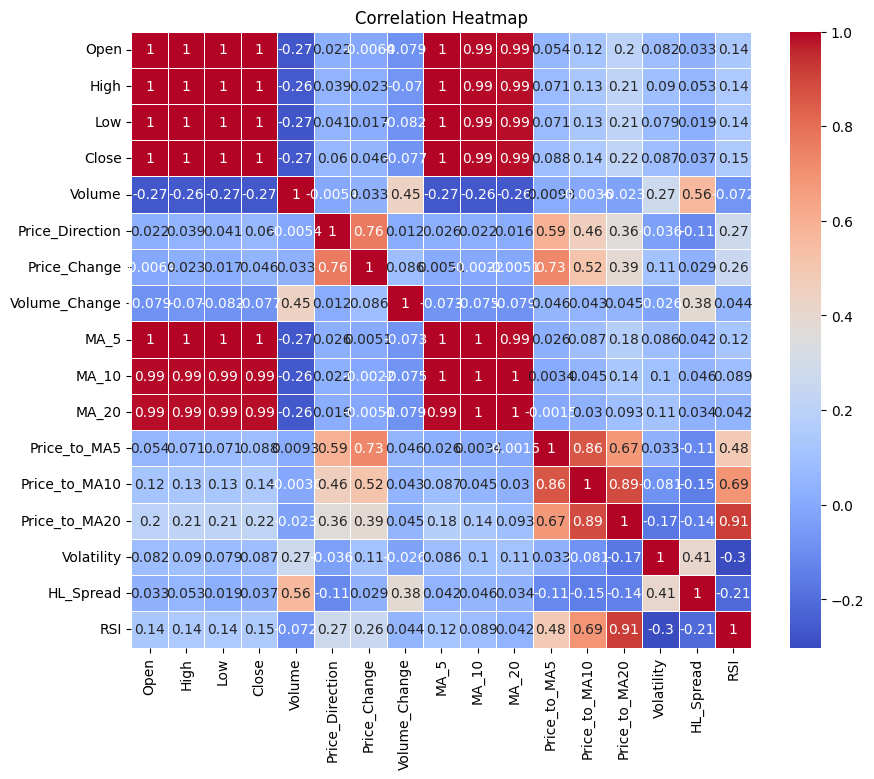

In [25]:
# correlation heatmap
correlation_matrix = weekly_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Prep features for LTSM


In [26]:
#i used these features because, raw price colums dont generalize good across LTSM models, regular MA's have the same scaling issue as raw prices

feature_columns = ['Price_Change', 'Volume_Change','Price_to_MA5', 'Price_to_MA10', 'Price_to_MA20', 'Volatility', 'HL_Spread', 'RSI']

# feature matrix

# features
features = weekly_data[feature_columns].values

# target variable
target = weekly_data['Price_Direction'].values

# Have to scale the features, for one not to have overwheliming influence than the others
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)






# Need to document this part, but head is everywhere but here rn

def create_sequences(features, target, sequence_length):
    X,y = [], []
    for i in range(sequence_length, len(weekly_data)):
        X.append(features[i-sequence_length:i])
        y.append(target[i])
    return np.array(X), np.array(y)


sequence_length = 10
X, y = create_sequences(features_scaled, target, sequence_length)
print(f"Created {len(X)} sequences of length {sequence_length}")
print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")


Created 304 sequences of length 10
Feature shape: (304, 10, 8)
Target shape: (304,)
